# Load data

In [48]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')
ds_sat_EOFs.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 ...
    EOF2                   (lat, lon) float32 ...>

# Plot EOFs

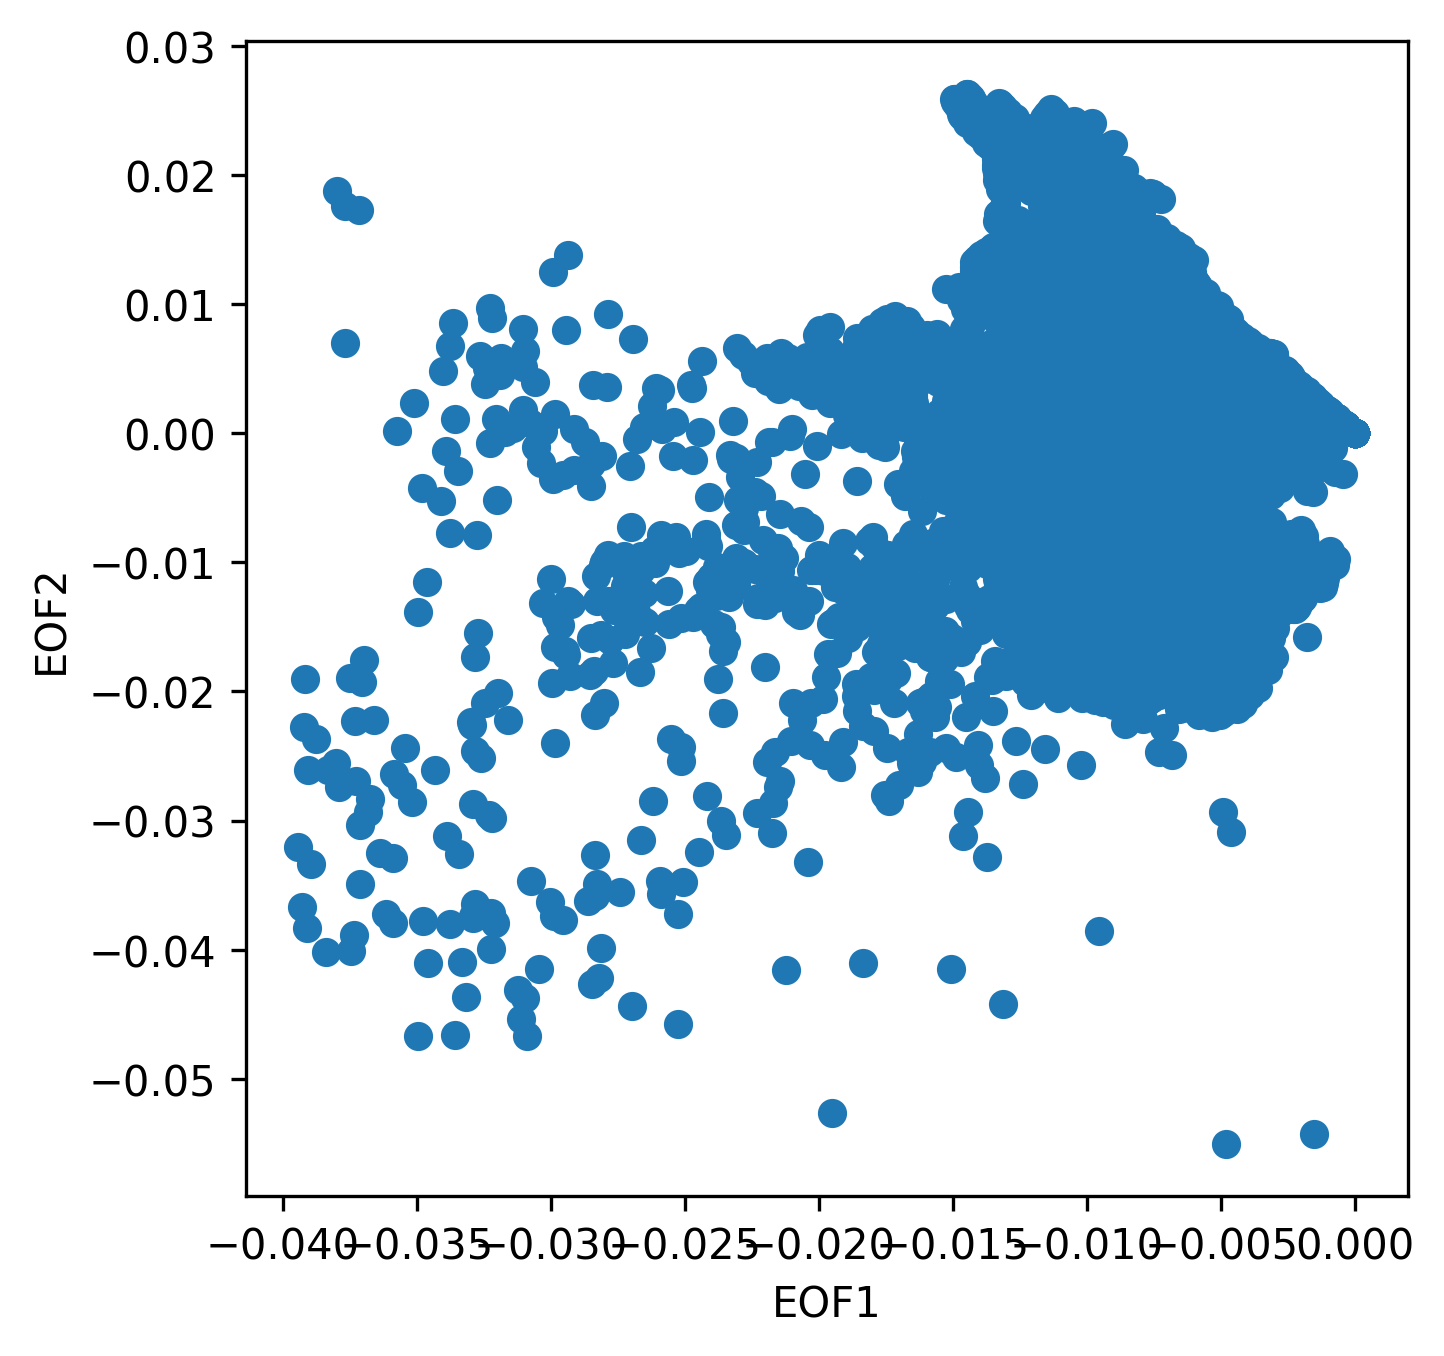

In [2]:
# plot the temp_score using 2d scatter plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
plt.scatter(ds_sat_EOFs['EOF1'].values.reshape(96*144,1), ds_sat_EOFs['EOF2'].values.reshape(96*144,1))
# add x and y labels
plt.xlabel('EOF1')
plt.ylabel('EOF2')

plt.show()

# Calculate the AIC and Determine the optimal number of classes

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming ds_sat_EOFs is your xarray Dataset
eof1_data = ds_sat_EOFs['EOF1'].values.flatten()
eof2_data = ds_sat_EOFs['EOF2'].values.flatten()

# Combine the reshaped EOF1 and EOF2 data
combined_data = np.column_stack((eof1_data, eof2_data))

# Define the range of number of components and the number of iterations
n_components_range = range(2, 9)  # 2 to 8 inclusive
n_iterations = 10

aic_values_dict = {}

# Loop over the range of components
for n_components in n_components_range:
    aic_values = []
    
    # Monte Carlo iterations
    for _ in range(n_iterations):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(combined_data)
        
        # Calculate and store the AIC for this fit
        aic_values.append(gmm.aic(combined_data))
    
    # Record the AIC values for this number of components
    aic_values_dict[n_components] = aic_values



# Plot AIC and delta AIC

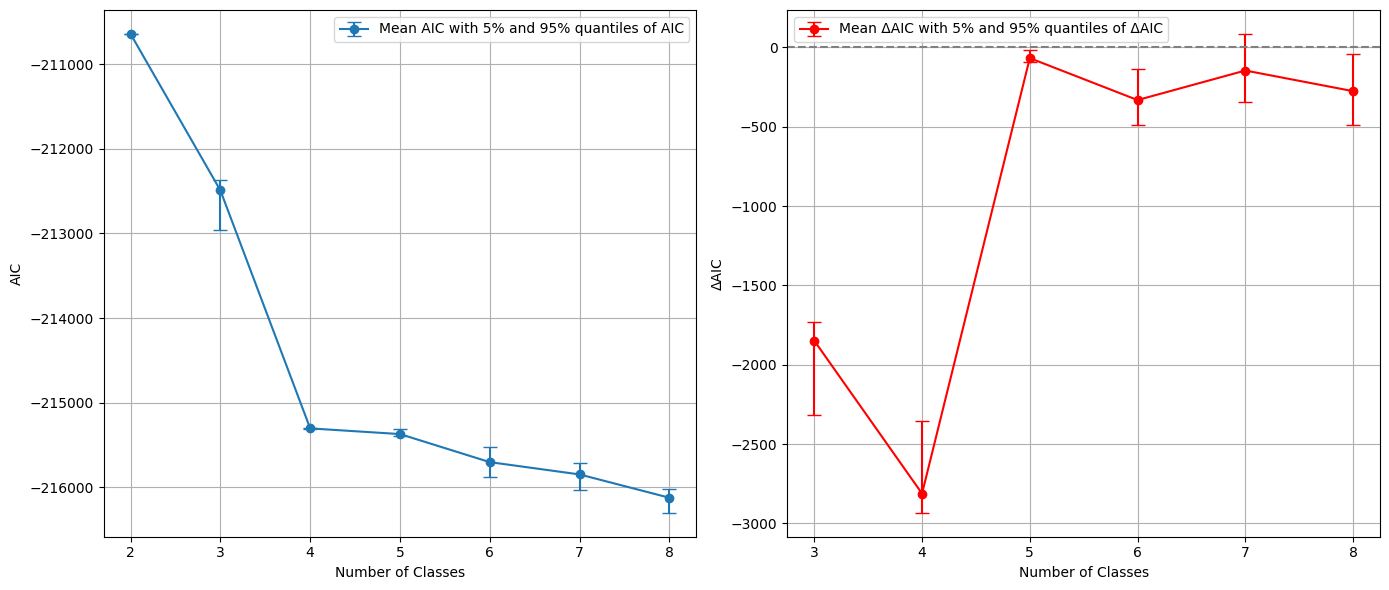

In [15]:
# Compute means, lower and upper limits
means = [np.mean(aic_values_dict[key]) for key in n_components_range]
lower_limits = [np.percentile(aic_values_dict[key], 5) for key in n_components_range]
upper_limits = [np.percentile(aic_values_dict[key], 95) for key in n_components_range]

# Differences from the mean for error bars
lower_errors = [mean - lower for mean, lower in zip(means, lower_limits)]
upper_errors = [upper - mean for mean, upper in zip(means, upper_limits)]

# Compute ΔAIC for each n_components during each Monte Carlo iteration
delta_aics_all_iterations = []
for i in range(n_iterations):
    iteration_delta_aics = np.diff([aic_values_dict[n][i] for n in n_components_range])
    delta_aics_all_iterations.append(iteration_delta_aics)

# Convert to a 2D numpy array for easier operations
delta_aics_all_iterations = np.array(delta_aics_all_iterations)

# Now, compute the mean ΔAIC and its 5% and 95% quantiles
delta_aics_means = np.mean(delta_aics_all_iterations, axis=0)
delta_aics_lowers = np.percentile(delta_aics_all_iterations, 5, axis=0)
delta_aics_uppers = np.percentile(delta_aics_all_iterations, 95, axis=0)

# Differences from the mean ΔAIC for error bars
delta_lower_errors = delta_aics_means - delta_aics_lowers
delta_upper_errors = delta_aics_uppers - delta_aics_means

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# AIC Plot
ax[0].errorbar(n_components_range, means, yerr=[lower_errors, upper_errors], 
               capsize=5, fmt='-o', label='Mean AIC with 5% and 95% quantiles of AIC')
ax[0].set_xlabel('Number of Classes')
ax[0].set_ylabel('AIC')
ax[0].legend()
ax[0].grid(True)

# ΔAIC Plot
ax[1].errorbar(n_components_range[1:], delta_aics_means, yerr=[delta_lower_errors, delta_upper_errors], 
               capsize=5, fmt='-o', color='red', label='Mean ΔAIC with 5% and 95% quantiles of ΔAIC')
ax[1].axhline(0, color='grey', linestyle='--')
ax[1].set_xlabel('Number of Classes')
ax[1].set_ylabel('ΔAIC')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Doing GMM using Monte Carlo

In [49]:
import numpy as np
import xarray as xr
from sklearn.mixture import GaussianMixture

# Assuming ds_sat_EOFs is your xarray Dataset
# 1. Reshape the EOF1 and EOF2 data
eof1_data = ds_sat_EOFs['EOF1'].values.flatten()
eof2_data = ds_sat_EOFs['EOF2'].values.flatten()

# 2. Combine the reshaped EOF1 and EOF2 data
combined_data = np.column_stack((eof1_data, eof2_data))

# Number of iterations for the Monte Carlo method
n_iterations = 10000
results = []

# 3. For each iteration, fit a GMM
for _ in range(n_iterations):
    gmm = GaussianMixture(n_components=4)
    # gmm = GaussianMixture(n_components=4, covariance_type='diag')
    gmm.fit(combined_data)
    labels = gmm.predict(combined_data)
    
    # Store results for each iteration
    results.append({
        'labels': labels,
    })

# At this point, results contains GMM outputs for 10 iterations


# Align labels accross iterations using Hungarian algorithm

Inspired by M. Osman's MATLAB code\
ref: \
https://en.wikipedia.org/wiki/Hungarian_algorithm
https://www.hungarianalgorithm.com/hungarianalgorithm.php
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

    The Hungarian algorithm, also known as the Kuhn-Munkres algorithm, 
    is a method to solve the assignment problem in polynomial time. The 
    assignment problem can be described as: given a square cost matrix 
    where each row represents a source, and each column represents a 
    target, assign each source to a target such that the total cost 
    is minimized.

\
row_ind represents the indices of the sources (i.e., rows of cost_matrix).\
col_ind represents the indices of the assigned targets for each source (i.e., columns of cost_matrix).\
The pair (row_ind[i], col_ind[i]) represents the optimal assignment for the i-th source to a target.

In [52]:
from scipy.optimize import linear_sum_assignment

def align_labels(reference_labels, labels_to_align):
    n_classes = len(np.unique(reference_labels))
    
    # Build the cost matrix
    cost_matrix = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            # define the cost, which decreases when the labels's index overlaps increases
            cost_matrix[i, j] = -np.sum((labels_to_align == i) & (reference_labels == j))
    
    # Use the Hungarian algorithm to find the best assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Permute the labels based on the optimal assignment
    aligned_labels = np.zeros_like(labels_to_align)
    for i, j in enumerate(col_ind):
        aligned_labels[labels_to_align == i] = j
        
    return aligned_labels




In [53]:
reference_labels = results[0]['labels']

# Align labels for every other iteration to the reference iteration
for i in range(1, n_iterations):
    results[i]['labels'] = align_labels(reference_labels, results[i]['labels'])

In [55]:
# store the results to a csv
data_dir = 'D:/VScode/Last_deglaciation/data'

import pickle

with open('D:/VScode/Last_deglaciation/data/results.pkl', 'wb') as f:
    pickle.dump(results, f)




# Plot label distributions in maps of all iterations

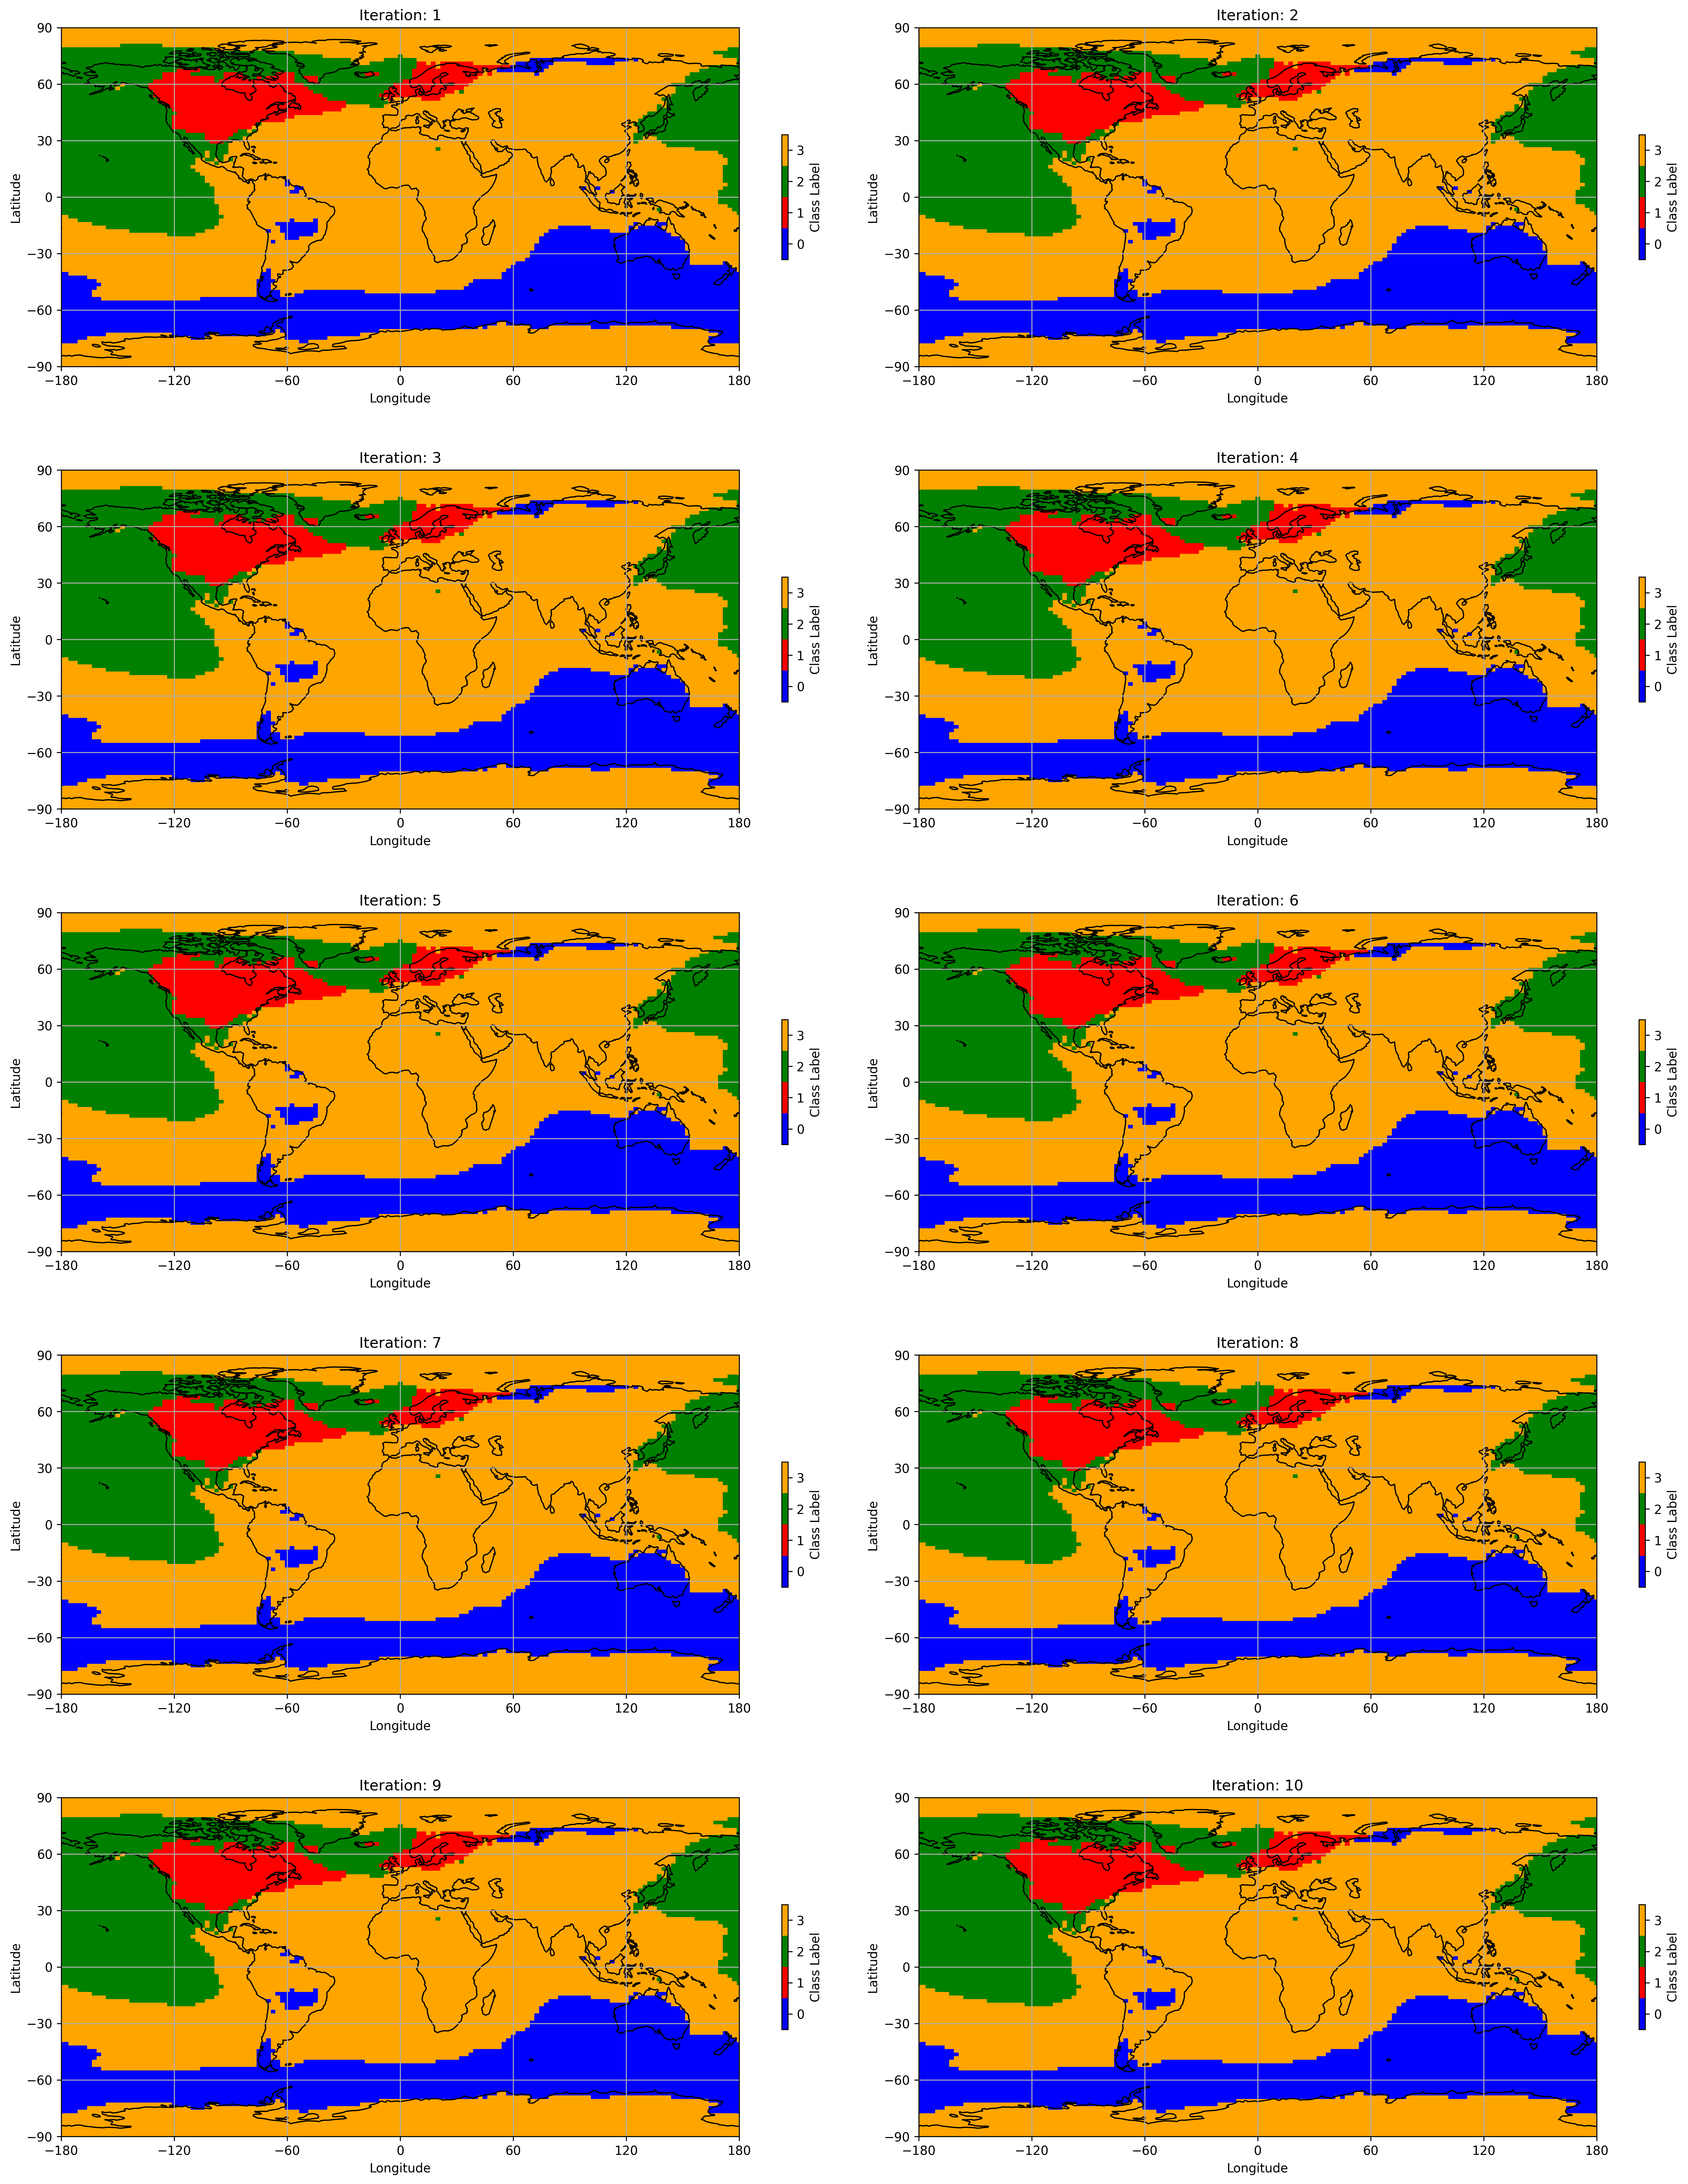

In [54]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# ... [your GMM code and the plot_labels function definition]

def plot_labels_on_axes(ds, ax):
    sat_label = ds['class_label']

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()

    # create colormap with unique colors for each class label
    cmap = mcolors.ListedColormap(colors[0:len(np.unique(sat_label))])

    im = ax.pcolormesh(ds.lon, ds.lat, sat_label, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')
    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Iteration: {ds.iteration.item()}')

    # add colorbar
    bounds = np.arange(len(np.unique(sat_label))+1) - 0.5
    ticks = np.arange(len(np.unique(sat_label)))
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, boundaries=bounds, ticks=ticks, shrink=0.3)

    cbar.ax.set_yticklabels(np.unique(sat_label))
    cbar.ax.set_ylabel('Class Label')

# get the first 10 results
if len(results) > 10:
    results_sampled = results[0:10]
else:
    results_sampled = results

# Decide number of rows based on length of results_sampled
n_rows = int(np.ceil(len(results_sampled) / 2))

# Generate plots
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(20, 5 * n_rows), dpi=300,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

# Ensure axes is always 2D for consistent indexing
if n_rows == 1:
    axes = np.array([axes])

lats = ds_sat_EOFs['lat'].values
lons = ds_sat_EOFs['lon'].values

for idx, result in enumerate(results_sampled):
    ds_temp = xr.Dataset({
        'class_label': (['lat', 'lon'], result['labels'].reshape(len(lats), len(lons))),
        'lat': (['lat'], lats),
        'lon': (['lon'], lons),
        'iteration': idx + 1
    })
    ax = axes[idx // 2, idx % 2]
    plot_labels_on_axes(ds_temp, ax)

plt.tight_layout()
plt.show()


# Get the age of termination initiation of each class for each iteration

10000
10000


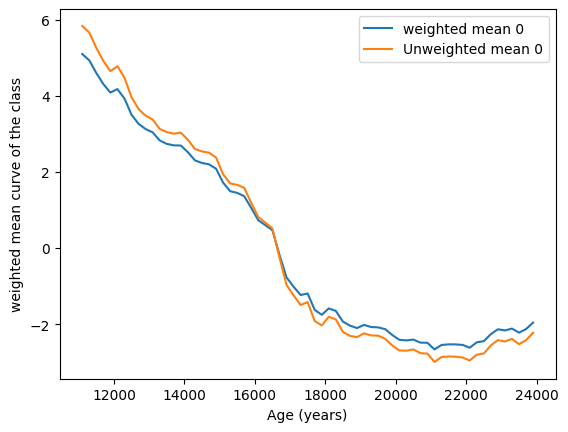

In [56]:
# 1. Extract the sat_centered data and extend weights
sat_centered_data = ds_sat_EOFs['sat_centered'].values

weights=ds_sat_EOFs['weight'].values

ages = ds_sat_EOFs['age'].values

# Reshape weights to have a shape of (number of latitudes, 1) and then broadcast it across all longitudes
weights_broadcasted = weights[:, np.newaxis] * np.ones(ds_sat_EOFs['lon'].shape[0])

# 2. Now, you can use weights_extended directly in the loop:
min_ages_all_iter = []
class_label_all_iter=[]

j=0
check_plot=True
for result in results:
    labels = result['labels'].reshape(ds_sat_EOFs['lat'].shape[0], ds_sat_EOFs['lon'].shape[0])
    min_ages = []
    class_label_pre_iter=[]
    for class_label in np.unique(labels): # the np.unique reture the sorted values (https://numpy.org/doc/stable/reference/generated/numpy.unique.html)
        # store the class_lable
        class_label_pre_iter.append(class_label)
        # Get the data points for this class
        data_for_class = sat_centered_data[:, labels == class_label]
        
        # Get the corresponding weights for this class
        weights_for_class = weights_broadcasted[labels == class_label]
        # print(data_for_class.shape)
        # print(weights_for_class.shape)
        
        # Calculate the weighted mean curve over all pixels for this class
        weighted_sum_of_class=0
        for i in range(data_for_class.shape[1]):
            weighted_sum_of_class += data_for_class[:,i] * weights_for_class[i]

        # # print(weighted_sum.shape)
        # # weighted_sum = np.sum(data_for_class[:,i] * weights_for_class[i] for i in range(data_for_class.shape[1]))
        total_weights = np.sum(weights_for_class)
        # print(total_weights)
        
        weighted_mean_curve = weighted_sum_of_class / total_weights

        if check_plot:
            if j==0:
                # Plot the weighted mean curve for this class
                plt.plot(ages, weighted_mean_curve, label='weighted mean {}'.format(class_label))
                # plot the unweighted mean curve for this class
                plt.plot(ages, np.mean(data_for_class, axis=1), label='Unweighted mean {}'.format(class_label))
                plt.legend()
                plt.xlabel('Age (years)')
                plt.ylabel('weighted mean curve of the class') 
            
                j+=1
        
        # Determine the age corresponding to the minimum of this weighted mean curve
        min_age_for_class = ages[np.argmin(weighted_mean_curve)]
        min_ages.append(min_age_for_class)
        
    min_ages_all_iter.append(min_ages)
    class_label_all_iter.append(class_label_pre_iter)

print (len(min_ages_all_iter))
print(len(class_label_all_iter))

# Calculate the distribution of termination initiation

In [57]:

# Transpose the list for easier column access
transposed_min_ages = list(zip(*min_ages_all_iter))

# Loop through each class
for class_idx, ages_for_class in enumerate(transposed_min_ages):
    print(f"Class {class_idx}:")

    # Find unique ages and their counts
    unique_ages, counts = np.unique(ages_for_class, return_counts=True)

    # Calculate and print the percentage for each unique age
    for age, count in zip(unique_ages, counts):
        percentage = (count / len(ages_for_class)) * 100
        print(f"Age: {age}, Percentage: {percentage:.2f}%")

    print("-" * 30)  # Separator for better visibility



Class 0:
Age: 17900.0, Percentage: 0.15%
Age: 21100.0, Percentage: 99.85%
------------------------------
Class 1:
Age: 17300.0, Percentage: 0.16%
Age: 17900.0, Percentage: 99.82%
Age: 21100.0, Percentage: 0.02%
------------------------------
Class 2:
Age: 17100.0, Percentage: 99.98%
Age: 17300.0, Percentage: 0.02%
------------------------------
Class 3:
Age: 17700.0, Percentage: 99.85%
Age: 21100.0, Percentage: 0.15%
------------------------------
